# Analysis of TES Data
## Using feature reduction and clustering
One script to rule them all!

In [54]:
# import libraries
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import mplcursors
import pyperclip
import datetime
import cupy as cp

from readTrc import Trc
from scipy import signal
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn import manifold

%matplotlib widget


# Load data

In [55]:
# This is the directory for the dataCR_ for the anabsalysis
data_dir            = './SECONDTHORIUM/DCR_14072023_Lito2_E20_and_Lito2_B20_thorium/'
channels            = ['C1','C2']

# Load the data per channel
filenames           = {channel: [file for file in os.listdir(data_dir) if channel in file] for channel in channels}
# Dont forget to sort them so that coincidences will match up correctly
for channel in channels:
    filenames[channel]=np.sort(filenames[channel])
    
# Load the data
trc_loader          = Trc()   # Create a loader object
traces              = {channel: [trc_loader.open(os.path.join(data_dir,filename)) for filename in filenames[channel]] for channel in channels}
# Implement time cuts
starttime=datetime.datetime(2023,7,14, 15,54) #second throium
endtime=datetime.datetime(2023,7,15, 9,32) #second throium


#oscilloscope_offset=datetime.timedelta(minutes=44)
#starttime=datetime.datetime(2023,7,6,18,46,16)+oscilloscope_offset ##times for initial run
#endtime=datetime.datetime(2023,7,7, 7,30,15)+oscilloscope_offset ##times for initial run
#starttime=datetime.datetime(2023,7,7,19,28,1) ##times for weeked run
#endtime=datetime.datetime(2023,7,8,7,5,51)##times for weeked run

intimetraces={channel:[] for channel in channels}
for channel in channels:
    for trace in traces[channel]:
        if (trace[2]['TRIGGER_TIME']<endtime and trace[2]['TRIGGER_TIME']>starttime):
            intimetraces[channel].append(trace)     
traces=intimetraces

# Load the Reference Pulses
reference_pulses    = pd.read_csv('./DATA/REFERENCE/reference.dat', skiprows=5, header=[0,1], sep='\t')

In [56]:
# plt.figure()
# for i in range(0,len(traces['C1'])):
#     plt.scatter(i, traces['C1'][i][2]['TRIGGER_TIME'])

# Oscilloscope Parameters

In [57]:
# The settings of the oscilloscope
CHANNEL             = channels[0]
REFERENCE_VOLTAGE   = signal.resample(reference_pulses['Amp_2ph_1.6eV'].to_numpy().T[0],len(traces[CHANNEL][0][0]))
trig_ch0 = -0.051
trig_ch1 = -0.045

# Filter the traces


In [58]:
# Select the traces that had nonzero signal (can add ch3 and ch4 in case we need PMT coincidence as well)
mask_ch0          = [np.min(data[1]) < trig_ch0 for data in traces[channels[0]]] #0.052
idx_triggered_ch0 = np.where(np.array(mask_ch0))[0]
triggered_ch0     = [traces[channels[0]][i] for i in idx_triggered_ch0]

mask_ch1          = [np.min(data[1]) < trig_ch1 for data in traces[channels[1]]]
idx_triggered_ch1 = np.where(np.array(mask_ch1))[0]
triggered_ch1     = [traces[channels[1]][i] for i in idx_triggered_ch1]

the_data          = triggered_ch0
the_data_index    = idx_triggered_ch0

# Data info

In [59]:
# Check loaded event's name and total number of signals
print(filenames['C2'][1])
print(len(traces['C2']))

C2--DCR_thorium_Lito2_E20_tr51mV_8p1uA_Lito2_B20_tr45mV_7p66uA_43mK_nofilter--00001.trc
2324


In [60]:
# Note event times
print(traces['C1'][0][2]['TRIGGER_TIME'])
print(traces['C1'][2323][2]['TRIGGER_TIME'])
print(traces['C1'][2323][2]['TRIGGER_TIME']-traces['C1'][0][2]['TRIGGER_TIME'])


2023-07-14 15:54:59.262199
2023-07-15 09:30:47.612999
17:35:48.350800


In [61]:
# ?
#print(reference_pulses)

# Note Number of Multicoincidence

In [62]:
# # Select coincidence events and print their quantity and indexes.
mask_coinc=[(mask_ch0[i] and mask_ch1[i]) for i in range(0,len(mask_ch0))]

print(np.unique(mask_ch0,return_counts=True))
print(np.unique(mask_ch1,return_counts=True))
print(np.unique(mask_coinc, return_counts=True))

idx_coinc = np.where(np.array(mask_coinc))[0]
print(list(idx_coinc))


(array([False,  True]), array([ 874, 1450]))
(array([False,  True]), array([1412,  912]))
(array([False,  True]), array([2283,   41]))
[4, 15, 25, 33, 206, 246, 329, 418, 455, 499, 623, 655, 714, 785, 821, 901, 987, 1070, 1261, 1346, 1399, 1564, 1579, 1686, 1738, 1777, 1858, 1889, 1925, 1926, 2032, 2096, 2111, 2174, 2188, 2213, 2214, 2253, 2277, 2307, 2323]


In [63]:
# for i in idx_coinc[40:]:
#     if (np.min(traces['C1'][i][1]) < trig_ch0) and (np.min(traces['C2'][i][1]) < trig_ch1):
#         plt.figure()
#         plt.plot(traces['C1'][i][0],traces['C1'][i][1])
#         plt.plot(traces['C2'][i][0],traces['C2'][i][1])
#         plt.show()

# Useful Functions

In [64]:
def plot_signal(voltage,fig=None,ax=None,order=2,mysize=1/50,**kwargs):
    '''
    Returns a Pyplot figure of the smoothed voltage signal as a function of
    event number
    '''
    #butterybiscuits=signal.wiener(voltage,mysize=11)
    sos=signal.butter(order,mysize, output='sos')
    butterybiscuits=signal.sosfilt(sos,voltage)
    
    if fig is None: fig = plt.figure()
    if ax is None: ax  = fig.add_subplot(111)
    
    ax.plot(butterybiscuits,**kwargs)
    
    return fig,ax

In [82]:
def values_of_interest(time,data,order=2,mysize=1/50):
    sos=signal.butter(order,mysize, output='sos')
    butterybiscuits=signal.sosfilt(sos,data)
    
    peak            = np.argmin(butterybiscuits)
    area            = np.sum(butterybiscuits[:-1]*(time[1:]-time[:-1]))
    peakheight      = np.min(butterybiscuits)
    halfheights     = np.where(butterybiscuits-peakheight/2<0)[0]
    fwhm            = 0 if len(halfheights)<1 else time[halfheights[-1]]-time[halfheights[0]]
    medheight       = np.median(butterybiscuits)
    meanheight      = np.mean(butterybiscuits)
    meantime        = np.mean(np.abs(butterybiscuits)*(time))/np.sum(np.abs(butterybiscuits[:-1])*(time[1:]-time[:-1]))
    std             = np.std(butterybiscuits)
    grad            = (butterybiscuits[1:]-butterybiscuits[:-1])/(time[1:]-time[:-1])
    grad_min        = np.mean(grad[np.where(grad<0)])
    grad_max        = np.mean(grad[np.where(grad>0)])
    corr            = signal.correlate(butterybiscuits/np.min(butterybiscuits)*np.min(REFERENCE_VOLTAGE),REFERENCE_VOLTAGE)
    area_cumulative = np.cumsum(butterybiscuits[:-1]*(time[1:]-time[:-1]))
    cumt_percentage = area_cumulative/area
    percentage      = 0.98
    time_at_98_perc = time[np.argmax(cumt_percentage >= percentage)]
    
    return ((np.abs(meantime-fwhm))/meantime, peakheight/area, time_at_98_perc, (meantime-time[peak])/, peakheight,std/area, np.sqrt(np.mean(grad**2)),grad_min,grad_max,np.max(corr))

# Feature Reduction

In [83]:
# Get the data for each of the pulses
values      = cp.array([values_of_interest(*data[:2],order=1,mysize=1/300) for data in tqdm(the_data)])

# Center data
mu          = cp.tile(np.mean(values,axis=0),len(values)).reshape(values.shape)
X_centered  = (values-mu)
X_centered  = X_centered / cp.tile(np.max(X_centered,axis=0)-cp.min(X_centered,axis=0),len(X_centered)).reshape(X_centered.shape)

# Single Value Decomposition
u,s,vT      = cp.linalg.svd(X_centered)

  0%|          | 0/1450 [00:00<?, ?it/s]

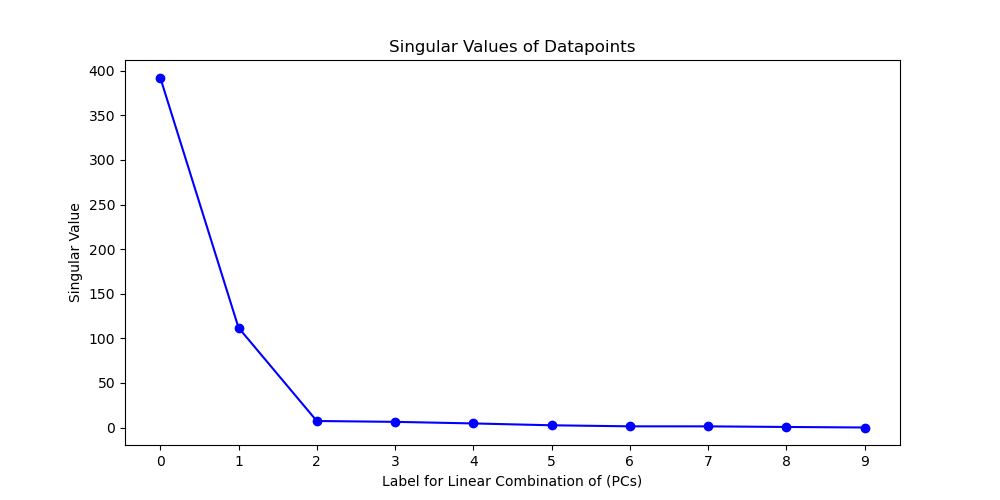

In [84]:
# plot the singlar values for the  D  matrix.
# 1. Calculate the D matrix using s: D is s*s
D       = cp.asnumpy(s*s)
labels  = range(len(X_centered[0]))

# 2. Set the fig size to (15,5)
fig     = plt.figure(figsize=(10,5))
ax      = fig.add_subplot(111)

# 3. Add the line chart using plt.plot( ?? ,'bo-')
ax.plot(labels,D,'bo-')

# 3. Add proper tital, ticks, axis labels
ax.set_title('Singular Values of Datapoints')
ax.set_xlabel('Label for Linear Combination of (PCs)')
ax.set_ylabel('Singular Value')
ax.set_xticks(labels)
# ax.set_yscale('log')

plt.show()

In [85]:
# Obtaining our compressed data representation:
# 1. Determine at least k singular values that are needed to represent the data set from the fig above
k = np.array(list(labels))

# 2. Obtain the first k of v^T and store it
v = vT[k].T

# 3. Calculate the compressed data using np.matmul(), X and stored first k of v^T
X_compressed = cp.matmul(X_centered,v).get()

# 4. Print the compressed value of X
#print(v)

# K-Means++ Clustering

In [86]:
# PARAMETERS
N_CLUSTERS  = 9
pyper       = []

<function __main__.<lambda>(sel)>

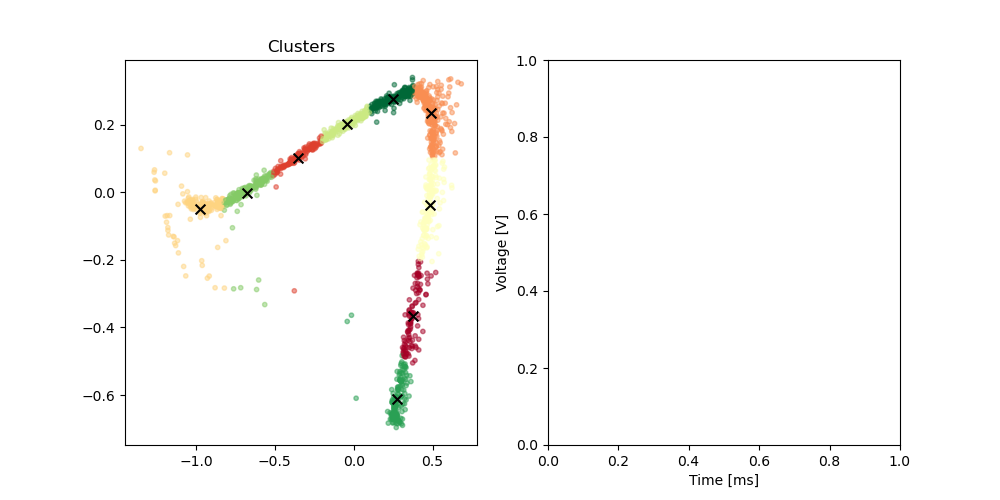

In [87]:
%matplotlib widget

# Get the centers
DATA    = X_compressed[:,[0,1]] #X_centered[:,[0,-1]] #

# params = {
#     "n_neighbors": 100,
#     "n_components": 2,
#     "eigen_solver": "dense",
#     "random_state": 0,
#     }

# lle_hessian = manifold.LocallyLinearEmbedding(method="hessian", **params)
# DATA = lle_hessian.fit_transform(DATA)

kmeans  = KMeans(n_clusters=N_CLUSTERS, n_init="auto").fit(DATA)
closestpoints=[]

fig     = plt.figure(figsize = (10,5))
ax1     = fig.add_subplot(121)
ax2     = fig.add_subplot(122)
cmap    = matplotlib.cm.get_cmap('RdYlGn')
COLORS  = np.array([kmeans.predict([x[:2]])[0] for x in DATA])
norm    = matplotlib.colors.Normalize(vmin=COLORS.min(),vmax=COLORS.max())
points  = ax1.scatter(*(DATA.T),s=10,alpha=0.5,c=cmap(norm(COLORS)))
centers = ax1.scatter(*kmeans.cluster_centers_.T,color='k',marker='x',s=50)
ax1.set_title('Clusters')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Voltage [V]')
IDX_SELECTED  = []

cursor_p = mplcursors.cursor(points)

def callback(sel):
    I = sel.index
    cursor_p.visible = True
    cursor_c.visible = False
    sel.annotation.set_text(sel.index)
    fig.suptitle(f'Idx {I}')
    ax2.clear()
    pyper.append(I)

    plot_signal(the_data[I][1],fig=fig,ax=ax2,order=0,mysize=1/50,color='k',alpha=0.2,lw=0.5)
    plot_signal(the_data[I][1],fig=fig,ax=ax2,order=2,mysize=1/50,color='k',lw=1)
    ax2.plot(REFERENCE_VOLTAGE*the_data[I][1].min()/REFERENCE_VOLTAGE.min(), color='deepskyblue',lw=1,ls=(0,(5,10)))
    sel.annotation.get_bbox_patch().set(fc="white",lw=0,alpha=0)
    sel.annotation.arrow_patch.set(arrowstyle="]-", fc="k")
    CC = ['k']*9
    CC[COLORS[I]] = 'deeppink'
    centers.set_color(CC)

    val    = values[I]
    function_name = ["fwhm", "peakheight/area", "time_at_98_perc", "(meantime-time[peak])/peakheight", "std", "area", "np.sqrt(np.mean(grad**2))", "grad_min", "grad_max", "np.max(corr)"]
    max_name_width = max(len(name) for name in function_name)
    print("-" * (max_name_width + 30))
    print(f"{[I]},{'Name':<{max_name_width}}\tResult")
    for i, name in enumerate(function_name):
        result = val[i]
        print(f"{name:<{max_name_width}}\t{result}")
    
cursor_p.connect("add", lambda sel: callback(sel))


cursor_c = mplcursors.cursor(centers)

def callback_center(sel):
    I = sel.index
    idx_c = np.where(COLORS==I)[0]
    sel.annotation.set_text(len(idx_c))
    sel.annotation.get_bbox_patch().set(fc="white",lw=0,alpha=0)
    sel.annotation.arrow_patch.set(arrowstyle="wedge", fc="k")
    fig.suptitle(f'Center {I}')
    ax2.clear()
    cursor_p.visible = False
    cursor_c.visible = True
    #pyperclip.copy(", ".join([str(i) for i in idx_c]))
    #PYPER = eval("[" + ", ".join([str(i) for i in idx_c]) + "]")
    pyper.append(idx_c)
    print(len([str(i) for i in idx_c]))
    print((", ".join([str(i) for i in idx_c])))
    CC = ['k']*9
    CC[I] = 'cornflowerblue'
    centers.set_color(CC)

    ax2.set_title(f'Number of Points {len(idx_c)}')
    for i in idx_c:
        #plot_signal(the_data[I][1],fig=fig,ax=ax2,order=0,mysize=1/50,color='k',alpha=0.2,lw=0.5)
        plot_signal(the_data[i][1],fig=fig,ax=ax2,order=2,mysize=1/50,lw=1,label=f'{i}')
    
cursor_c.connect('add', lambda sel:callback_center(sel))

In [71]:
print(pyper)
print(len(pyper))

[]
0


In [72]:
# df = pd.read_csv('SCINT_COINC_THIRDWEEK/DCR_19072023_Lito2_B20_PMT_1_2_4/2023_07_19_16_48CD166 DCR 3pmt.csv')

# # print(df.info())
# col1 = df.iloc[:, 0]
# col4 = df.iloc[:, 3]

# plt.plot(col1.iloc[3:], col4.iloc[3:])
# plt.xlabel('Time')
# plt.ylabel('Temp')

# plt.axhline(y=0.042, color='r')
# plt.axhline(y=0.043, color='y')

# def on_click(event):
#     if event.xdata is not None and event.ydata is not None:
#         x_clicked = event.xdata
#         y_clicked = event.ydata
#         print(f"(x, y): ({x_clicked:.2f}, {y_clicked:.2f})")

# plt.gcf().canvas.mpl_connect('button_press_event', on_click)
# plt.show()

In [73]:
c2max=0
c1max=0
for i in range(0,len(traces['C2'])):
    if -1*np.min(traces['C1'][i][1])>c1max:
        c1max=-1*np.min(traces['C1'][i][1])
    if -1*np.min(traces['C2'][i][1])>c2max:
        c2max=-1*np.min(traces['C2'][i][1])
        
print(c1max)
print(c2max)


0.3813862381502986
0.30070242285728455


In [74]:
selected=[206, 329, 455,
          499, 623, 655, 821, 901,
          987, 1261, 1399, 1564, 1777, 
          1858,2096, 2111, 2277, 2307]




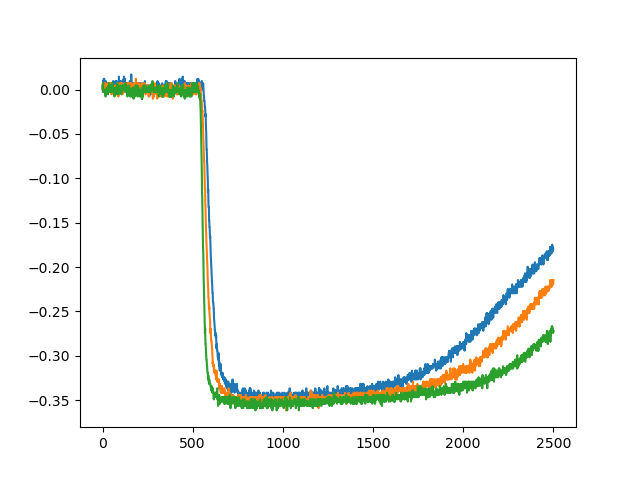

In [75]:
plt.figure()
for i in selected[-20:-15]:
    plt.plot(traces['C1'][i][1])

In [76]:
delay=[]
ampratio=[]
for i in range(0,len(selected)):
    t1=traces['C1'][i][0][np.argmin(np.abs(traces['C1'][i][1]+0.052))]
    t2=traces['C2'][i][0][np.argmin(np.abs(traces['C2'][i][1]+0.052))]
    delay.append((t1-t2)*1000000)
    ampratio.append((-1*np.min(traces['C1'][i][1])/c1max) / (-1*np.min(traces['C2'][i][1])/c2max))

In [77]:
nontamp=[0.05755183296053407, 0.056202526445830646, 0.36084173306135814, 16.010431961458764, 20.672108007244372, 11.792725062890833, 0.3101907011694084, 26.409894978929664]
nontdelay=[-13.509384771324676, -11.361718924343297, -2.609198762828471, 13.084802197583443, -21.015661181606074, 2.9874217395516394, -2.9082905130687666, -33.83801313636701]
nonttrigdelay=1000000*np.array([1.868000188647284e-05, -5.319997967667856e-06, -4.2799979739884255e-06, 1.3000001920992876e-05, -2.1119997871643814e-05, 3.6000001781211044e-05, 2.384000185511309e-05, -3.3839997794338384e-05])

Text(0.5, 0, 'Ratio of Normalized C1 Amplitude to Normalized C2 Amplitude ')

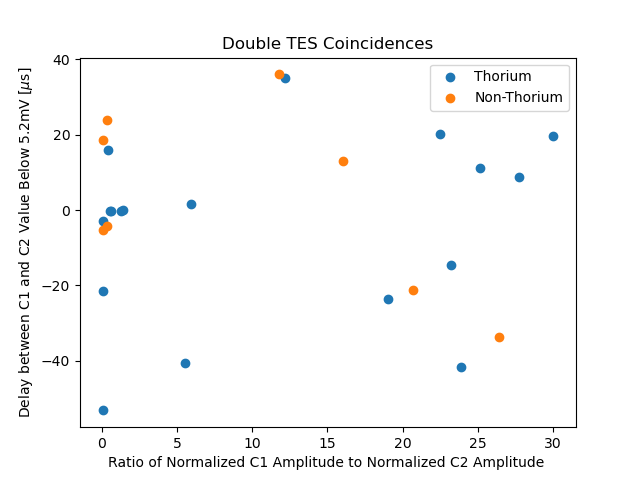

In [78]:
plt.figure()
plt.scatter(ampratio,delay,label='Thorium')
plt.scatter(nontamp,nonttrigdelay,label='Non-Thorium')
plt.title("Double TES Coincidences")
plt.legend()
plt.ylabel(r'Delay between C1 and C2 Value Below 5.2mV [$\mu$s]')
plt.xlabel('Ratio of Normalized C1 Amplitude to Normalized C2 Amplitude ')

Text(0.5, 1.0, 'Chan1 TES E')

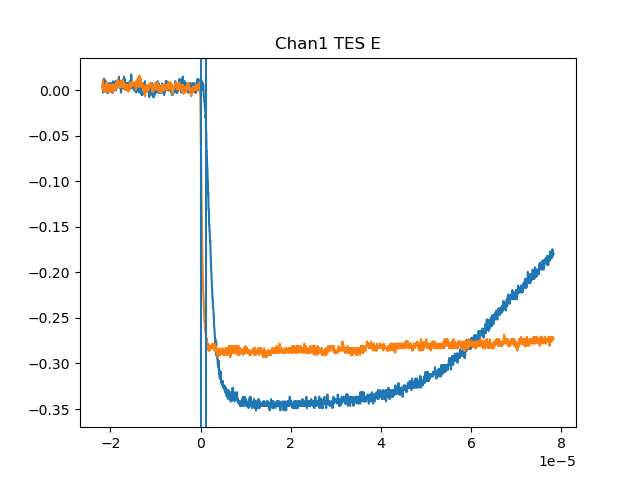

In [79]:
plt.figure(22)
for i in selected[:1]:
    plt.plot(traces['C1'][i][0],traces['C1'][i][1])
    plt.plot(traces['C2'][i][0],traces['C2'][i][1])
    plt.axvline(traces['C1'][i][0][np.argmin(np.abs(traces['C1'][i][1]+0.052))])
    plt.axvline(traces['C2'][i][0][np.argmin(np.abs(traces['C2'][i][1]+0.052))])
plt.title('Chan1 TES E')

In [80]:
selected=np.unique([548])
# print(len(selected))
# selected=[4, 211, 600, 760, 
#           869,
#           972, 1063, 1484,
#           1519, 1554]

#selected=np.unique([4, 211, 600, 760,
#                    869, 
#                    972, 1063, 1484, 1519, 1554])

# selected=[300, 373, 446, 448, 449,
#           450, 457, 510, 521, 524, 533, 568,
#           218, 447, 511, 562, 567, 569, 570, 451]
print(len(selected))

1


KeyError: 'C3'

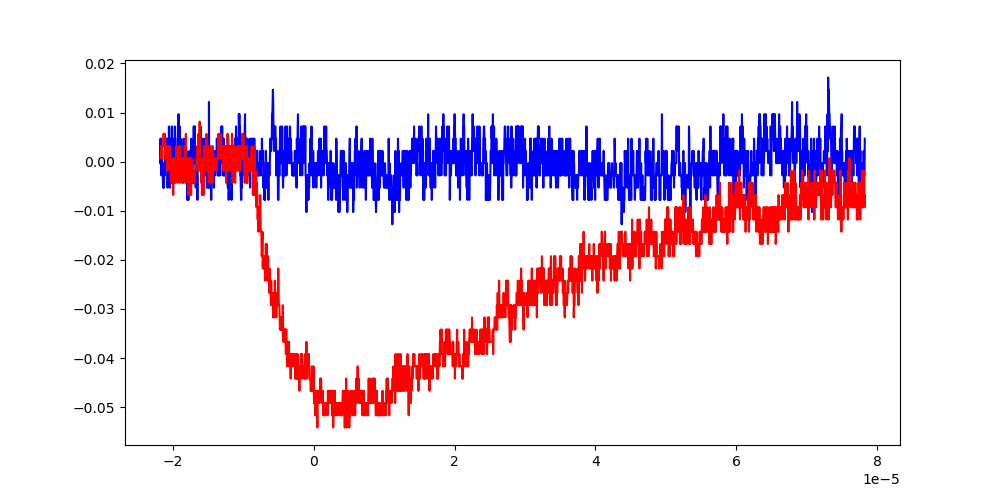

In [81]:
i=548
fig     = plt.figure(figsize = (10,5))
ax1     = fig.add_subplot(111)
ax1.plot(traces['C1'][i][0],traces['C1'][i][1],color='b',label='Scint 1 Chan 1')
ax1.plot(traces['C2'][i][0],traces['C2'][i][1],color='r',label ='TES B Chan 2')
ax1.plot(traces['C3'][i][0],traces['C3'][i][1],color='orange',label='Scint 2 Chan 3')
ax1.plot(traces['C4'][i][0],traces['C4'][i][1],color='green',label='Scint 3 Chan 4')
ax1.set_xlabel('time [s]')
ax1.legend()
ax1.set_title('Quadruple Coincidence of Muon Sabers and TES')


In [ ]:
print(len(selected))

1


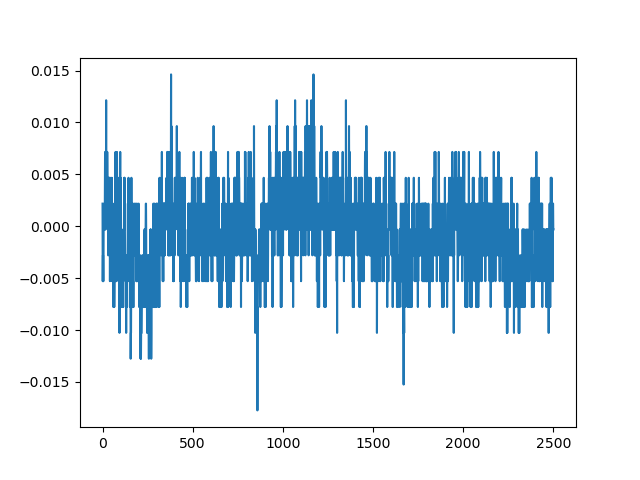

In [ ]:
plt.figure()
for i in selected[:]:
    plt.plot(othertes_filtered[i][1])

In [ ]:
traceamp=[]
tracearea=[]
for i in range(0,len(traces_filtered)):
    traceamp.append(-1*traces_filtered[i][1].min())
    tracearea.append(-1*np.sum(traces_filtered[i][1]))

Text(0.5, 1.0, 'TES B Chan2 Thorium VS non-Thorium')

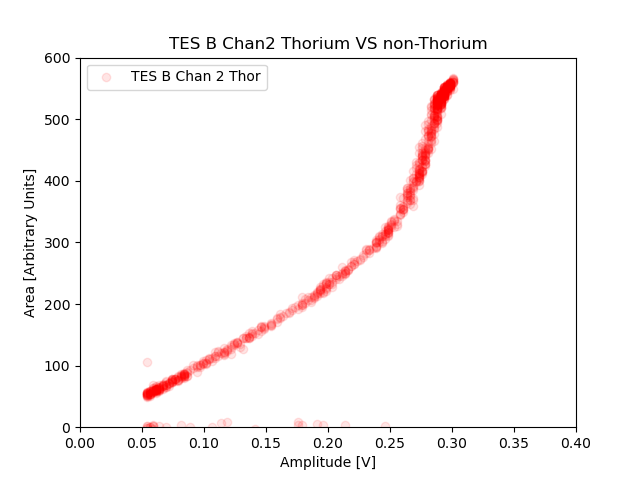

In [ ]:
plt.figure()
#plt.scatter(traceamp,tracearea,color='b',alpha=0.1,label='TES B Chan 2 Non-Thor')
plt.scatter(traceampthor,traceareathor,color='r', alpha=0.1,label='TES B Chan 2 Thor')
plt.ylabel('Area [Arbitrary Units]')
plt.xlabel('Amplitude [V]')
plt.legend()
plt.xlim(0,0.4)
plt.ylim(0,600)
plt.title('TES B Chan2 Thorium VS non-Thorium')

In [ ]:
times=[]
for i in range(0,len(traces['C1'])):
    times.append(traces['C1'][i][2]["TRIGGER_TIME"])
print(min(times))
print(max(times))
print(max(times)-min(times))

2023-07-14 15:54:59.262199
2023-07-15 09:30:47.612999
17:35:48.350800


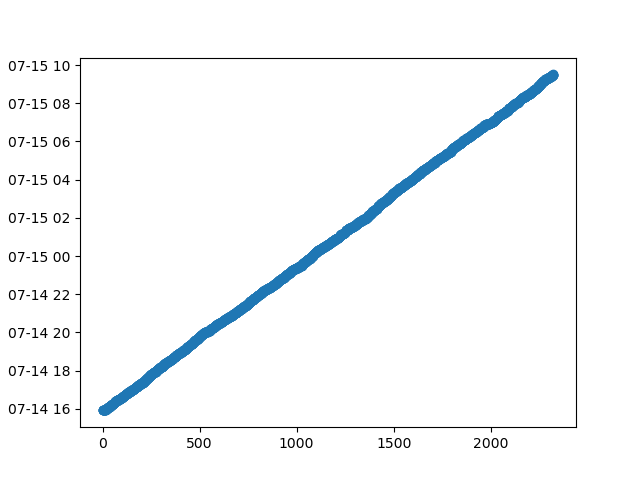

In [ ]:
plt.figure()
plt.scatter(np.arange(0,len(times)),times)
# plt.axhline(starttime,color='r')
# plt.axhline(endtime,color='r')

In [ ]:
intercept=0.01314
B1=0.03186
B2=6.17939e-4
B3=-7.01638e-5
evals=np.arange(0,13,0.01)
mvvals=intercept+evals*B1+evals**2*B2+evals**3*B3

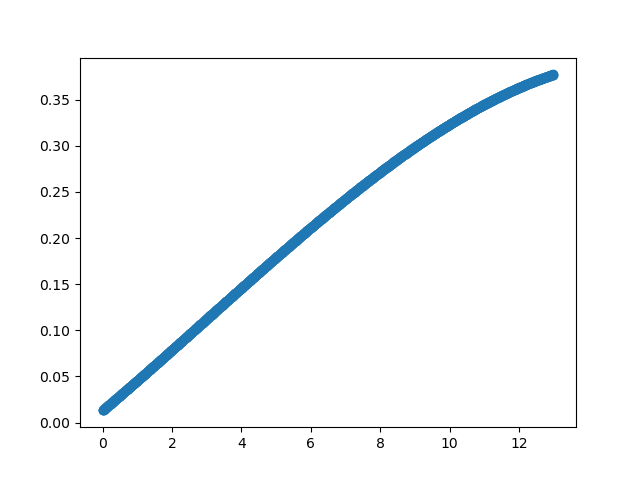

In [ ]:
plt.figure()
plt.scatter(evals,mvvals)

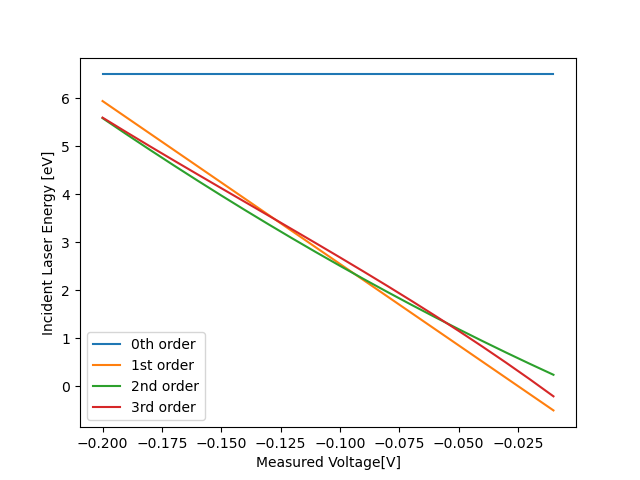

In [ ]:
plt.figure()
x=np.arange(-0.2,0,0.01)

poly0=np.polyfit(-1*mvvals,evals,0)
plt.plot(x,poly0[0]*x**0,label='0th order')
poly1=np.polyfit(-1*mvvals,evals,1)
plt.plot(x,poly1[1]+poly1[0]*x,label='1st order')
poly2=np.polyfit(-1*mvvals,evals,2)
plt.plot(x,poly2[2]+poly2[1]*x+poly2[0]*x**2,label='2nd order')
poly3=np.polyfit(-1*mvvals,evals,3)
plt.plot(x,poly3[3]+poly3[2]*x+poly3[1]*x**2+poly3[0]*x**3,label='3rd order')
plt.xlabel("Measured Voltage[V]")
plt.ylabel("Incident Laser Energy [eV]")
plt.legend()


In [ ]:
energylist=[]
for i in selected:
    minV=min(traces_filtered[i][1])
    maxE=poly3[3]+poly3[2]*minV+poly3[1]*minV**2+poly3[0]*minV**3
    energylist.append(maxE)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([7.82179143, 7.84179143, 7.86179143, 7.88179143, 7.90179143,
        7.92179143, 7.94179143, 7.96179143, 7.98179143, 8.00179143,
        8.02179143, 8.04179143, 8.06179143, 8.08179143, 8.10179143,
        8.12179143, 8.14179143, 8.16179143, 8.18179143, 8.20179143,
        8.22179143, 8.24179143, 8.26179143, 8.28179143, 8.30179143,
        8.32179143, 8.34179143, 8.36179143, 8.38179143, 8.40179143,
        8.42179143, 8.44179143, 8.46179143, 8.48179143, 8.50179143,
        8.52179143, 8.54179143, 8.56179143, 8.58179143, 8.60179143,
        8.62179143, 8.64179143, 8.66179143, 8.68179143, 8.70179143,
        8.72179143, 8.74179143, 8.76179143, 8.78179143, 8.80179143,
        8.82179143]),
 <BarContainer object of 50 artists>)

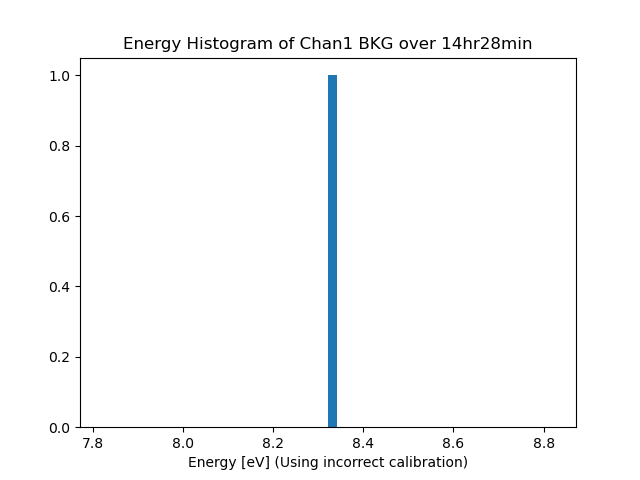

In [ ]:
plt.figure()
plt.title("Energy Histogram of Chan1 BKG over 14hr28min")
plt.xlabel("Energy [eV] (Using incorrect calibration)")
plt.hist(energylist,bins=50)